# Computational Methods in the Simulation and Analysis of the Cosmic Microwave Background and Cosmological Parameters

## Table of Contents

1. [Background](#background)
2. [CAMB Models](#camb)
3. [Generating CMB Map from Power Spectrum](#map)
4. [Simulating Instrumental Effects](#inst)
5. [Recovering Power Spectrum from Map](#power)
6. [Correcting Power Spectrum Estimates](#mcmc)
7. [Comparing Data to Theory](#act)
8. [References](#ref)

<a id="background"> </a>

## Background on the CMB and Cosmological Parameters

### What is the CMB?

The Cosmic Microwave Background (CMB) is light emitted at the epoch of recombination, when the universe cooled enough to form neutral atoms and allow photons to travel freely rather than being scattered. The CMB is nearly uniform, with an average temperature of about 2.7 K, but it has tiny fluctuations across the sky resulting from small variations in the density of matter in the early universe.

### What is the power spectrum of the CMB?

The size of these temperature fluctuations can be visualized through the angular power spectrum, which plots the amplitude of temperature variation against the “multipole moment,” which corresponds to an inverse angle of separation. Analyzing raw CMB data to produce sky maps and angular power spectra is a computationally challenging task, since it requires decomposing the map into spherical harmonics for a 3D Fourier transform, as well as accounting for instrumental and astrophysical effects.

### What does the CMB have to do with cosmological parameters?

CMB anisotropies encode a variety of cosmological parameters describing the composition and dynamics of the universe. The locations and heights of the acoustic peaks of the power spectrum are closely related to features like spatial geometries and baryon density. The plot above shows the power spectra of four model universes, as generated by the WMAP experiment CAMB code.

<a id="camb"> </a>

## CAMB models with varying parameters

I used the WMAP experiment CAMB interface (https://lambda.gsfc.nasa.gov/toolbox/tb_camb_form.cfm) to generate power spectra for different model universes with very different cosmological parameters.

In [2]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline

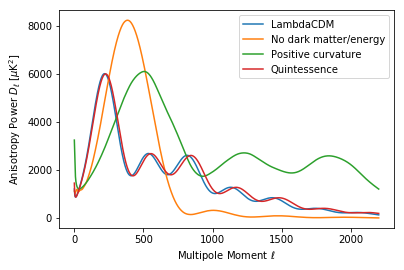

In [3]:
# Basic Lambda-CDM model
standard = np.loadtxt("camb_lcdm.dat", usecols=(0, 1), unpack=True)
plt.plot(standard[0], standard[1], label='LambdaCDM')

# No dark matter or dark energy, so baryon density = 1
nodark = np.loadtxt("camb_nodark.dat", usecols=(0, 1), unpack=True)
plt.plot(nodark[0], nodark[1], label='No dark matter/energy')

# Positive curvature, k = 1
curve = np.loadtxt("camb_k1.dat", usecols=(0, 1), unpack=True)
plt.plot(curve[0], curve[1], label='Positive curvature')

# Quintessence, equation of state ~ -1 but sound speed ~0
quint = np.loadtxt("camb_quint.dat", usecols=(0, 1), unpack=True)
plt.plot(quint[0], quint[1], label='Quintessence')

plt.ylabel('Anisotropy Power $D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('Multipole Moment $\ell$')


plt.legend()
plt.savefig('Power Spectra')
plt.show()

Since these models are pretty extreme, they do look visually different from the Lambda-CDM model, but no dark matter/energy and positive curvature significantly more so than quintessence. This is due to parameter degeneracy (the fact that different cosmological parameters can have very similar effects on the power spectra), which is why CMB power spectra alone are not enough to study dark energy theories like quintessence and phantom energy.

<a id="map"> </a>

## Generate map from power spectrum

The power plotted above on the y-axis is $D_{\ell}$ [$\mu$K$^2$], which is what you tend to see on power spectrum plots. However, what we need to work with is the angular power spectrum $C_\ell$ such that $D_\ell = \frac {\ell (\ell+1)} {2 \pi} C_\ell$. Below is the conversion being made below to calculate `Cpower` based on the $D_{\ell}$ plotted as `standard[1]`.

In [5]:
Cpower = standard[1] * 2 * np.pi / (standard[0]*(standard[0]+1.))

Setting the resolution of the map (it needs to be very fine so that we can perform many FFTs).

In [6]:
npix = 2**10  # number of pixels
pix_size  = 0.5 # size of a pixel in arcminutes

We can use a flat-sky approximation to simulate the images of many CMB telescopes that only scan small patches of the sky at a time. So, we simplify the spherical harmonics necessary for 3D CMB data analysis, and a 2D real space and 2D Fourier transforms are appropriate.

In [7]:
# creating a real 2D coordinate system that's basically a npix by npix grid over the plot
ones = np.ones(npix)
inds = np.linspace(-0.5, 0.5, npix)
X = np.outer(ones,inds) 
Y = np.transpose(X)
R = np.sqrt(X**2. + Y**2.)

Now make a 2D CMB power spectrum by transforming into Fourier space in polar coordinates. An important relation is $\ell = k* 2 \pi$ where $k = \sqrt{k_x^2 + k_y^2}$

In [9]:
pix_to_rad = (pix_size/60. * np.pi/180.) 
multi_scal = 2. * np.pi /pix_to_rad 
multi2d = R * multi_scal # turn the 2D real space above into fourier space using the relation l = k*2pi

Cpower_full = np.zeros(int(multi2d.max())+1) # zero vector for power spectrum, length of multi2d above
Cpower_full[0:(Cpower.size)] = Cpower 
Cpower2d = Cpower_full[multi2d.astype(int)] # use multi2d vector above as basis for 2D power spectrum

We need a Gaussian random realization as the background for our power spectrum. This is a random npix by npix grid that is transformed into Fourier space.

In [10]:
randomT = np.random.normal(0,1,(npix,npix)) 
fft_randomT = np.fft.fft2(randomT)   

Multiply power spectrum and random map (both in Fourier space) and inverse Fourier transform back to real space.

In [12]:
fft_2d = np.sqrt(Cpower2d) * fft_randomT
CMB_T = np.fft.ifft2(np.fft.fftshift(fft_2d)) 

# return from polar coordinates to pixel space for map, only keep real component
CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
CMB_T = np.real(CMB_T)

        

Plot the CMB_T map returned above with a color bar.

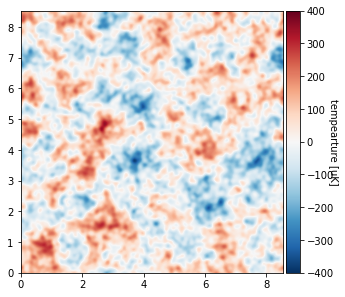

In [15]:
plt.figure(figsize=(5,5))
im = plt.imshow(CMB_T, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r) # actually plotting the data
im.set_clim(-400,400) # setting limits on color and size
im.set_extent([0,((2**10)*0.5/60),0,((2**10)*0.5/60)])

ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) # creating color bar off to the side
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('tempearture [uK]', rotation=270)
    
    

Now that we've explained and demonstrated every step, let's compile into 2 functions to reuse for other models.

In [16]:
def generate_map(npix, pix_size, multi, power): 
    
    Cpower = power * 2 * np.pi / (multi*(multi+1.))
    
    ones = np.ones(npix)
    inds = np.linspace(-0.5, 0.5, npix)
    X = np.outer(ones,inds) 
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    
    pix_to_rad = (pix_size/60. * np.pi/180.) 
    multi_scal = 2. * np.pi /pix_to_rad  
    multi2d = R * multi_scal 
    Cpower_full = np.zeros(int(multi2d.max())+1) 
    Cpower_full[0:(Cpower.size)] = Cpower 
    Cpower2d = Cpower_full[multi2d.astype(int)] 
    
    randomT = np.random.normal(0,1,(npix,npix))
    fft_randomT = np.fft.fft2(randomT)  
    
    fft_2d = np.sqrt(Cpower2d) * fft_randomT 
    CMB_T = np.fft.ifft2(np.fft.fftshift(fft_2d)) 
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)
    
    return CMB_T

In [17]:
def plot_map(tmap, x_size, y_size):
    plt.figure(figsize=(x_size,y_size))
    im = plt.imshow(tmap, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(-400,400)
    im.set_extent([0,((2**10)*0.5/60),0,((2**10)*0.5/60)])

    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('tempearture [uK]', rotation=270)

Using our new functions `generate_map` and `plot_map` on the 4 CAMB power spectra from above.

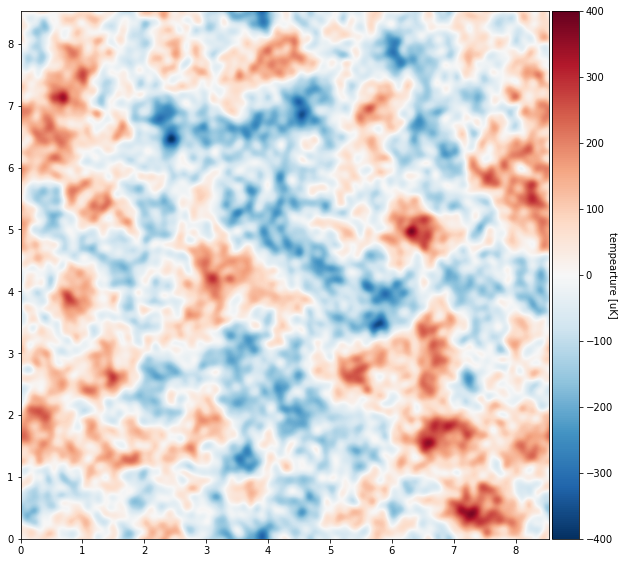

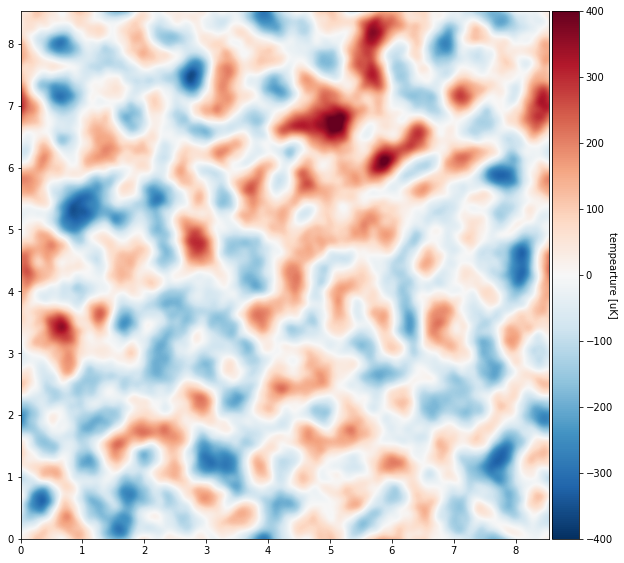

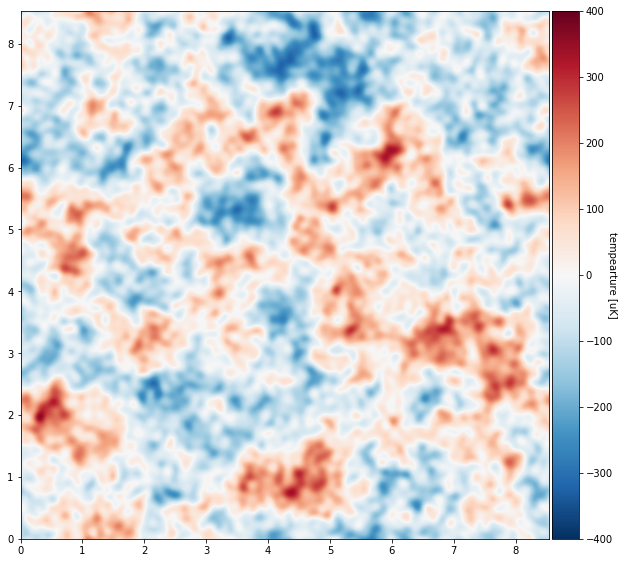

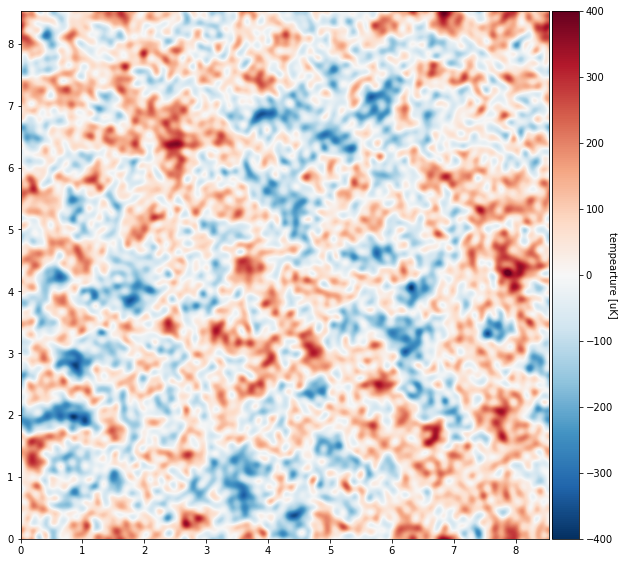

In [20]:
cmb = generate_map(npix,pix_size,standard[0],standard[1])
plot_map(cmb,10,10)

cmb_nodark = generate_map(npix,pix_size,nodark[0],nodark[1])
plot_map(cmb_nodark,10,10)

cmb_quint = generate_map(npix,pix_size,quint[0],quint[1])
plot_map(cmb_quint,10,10)

cmb_curve = generate_map(npix,pix_size,curve[0],curve[1])
plot_map(cmb_curve,10,10)

Similar to the power spectra above, the maps of the no dark matter/energy model and the positive curvature model are visually very different, but the quintessence model is almost indistinguishable from Lamda-CDM. 

<a id="inst"> </a>

## Add instrumental effects

This map is not yet realistic because there are other physical sources in the sky that a telescope will pick up and many changes that occur as data is measured and prepared for analysis. There are astrophyiscal effects like point sources and SZ distortion that we could add, but I'm choosing to only add beam, noise, and filtering instrumental effects because this is more interesting as an example of modeling and better aligned with the topics of this course. 

### Convolution with a beam

In [29]:
beam_size = 1 # in arcmins

def convolve(beam_size,tmap):
    # setting up the same 2D real space coordinates
    ones = np.ones(npix)
    inds = (np.arange(npix)+.5 - npix/2.) * pix_size
    X = np.outer(ones,inds) 
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    
    # creating a 2D Gaussian function
    beam_sigma = beam_size / np.sqrt(8.*np.log(2))
    gaussian = np.exp(-.5 *(R/beam_sigma)**2.)
    gaussian = gaussian / np.sum(gaussian)
  
    # convolving the beam with the map from earlier, shifts are necessary to align them both
    FT_gaussian = np.fft.fft2(np.fft.fftshift(gaussian)) 
    FT_map = np.fft.fft2(np.fft.fftshift(tmap)) 
    beam_conv = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_map))) 
    
    return beam_conv

Testing out beam effects with three different beam sizes that correspond to different experiments: 30 arcmin (B-mode observatories like BICEP and KECK array), 3 arcmin (medium resolution like Planck sattelite), and 1 arcmin (current high resolution telescopes like ACT and SPT). These demonstrate why it's important that we keep updating our instruments and building higher-resolution experiments because otherwise we cannot measure more sensitive anisotropy data.

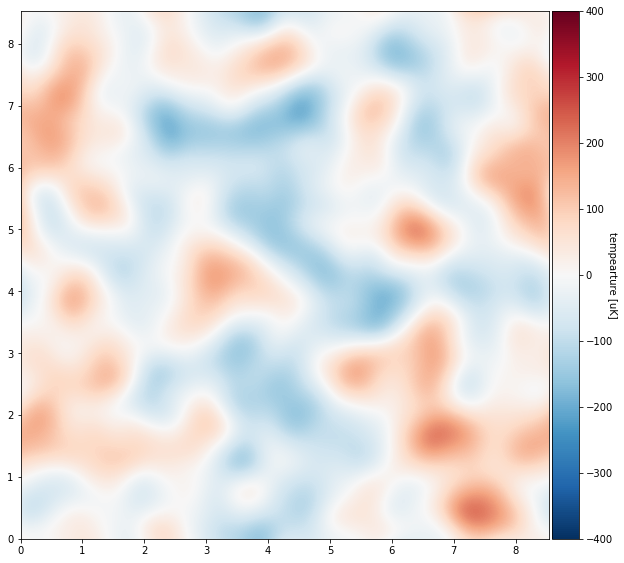

In [30]:
CMB_T_convolved = convolve(30,cmb)
plot_map(CMB_T_convolved,10,10)
plt.savefig('30 arcmin')

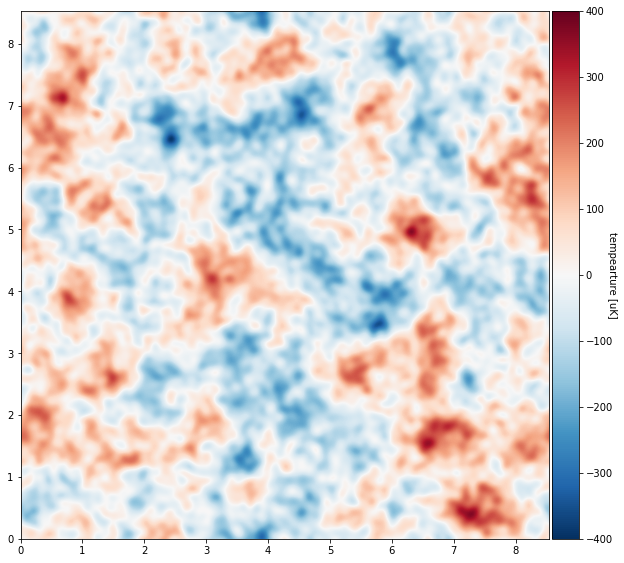

In [31]:
CMB_T_convolved = convolve(3,cmb)
plot_map(CMB_T_convolved,10,10)
plt.savefig('3 arcmin')

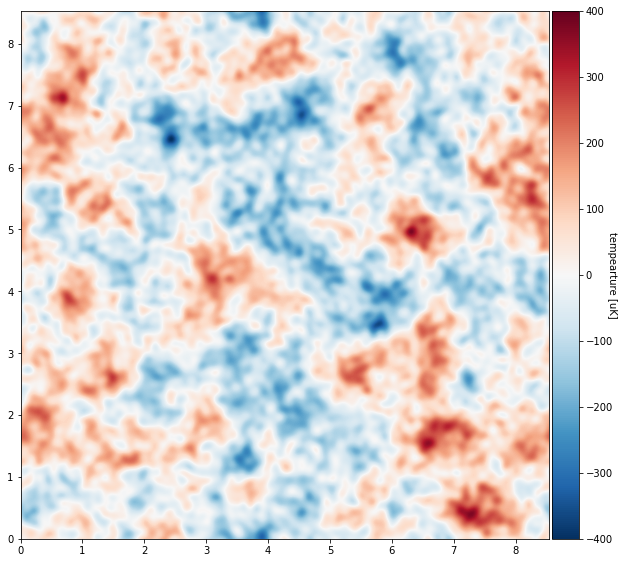

In [33]:
CMB_T_convolved = convolve(1,cmb)
plot_map(CMB_T_convolved,10,10)
plt.savefig('1 arcmin')

### White noise

There are a few different types of noise, but the simplest is white noise from a Gaussian distribution. The typical noise level for current experiments ACT and SPT is about 10 $\mu$K-arcmin, but I'm adding 30 $\mu$K just so the effect of noise is more apparent.

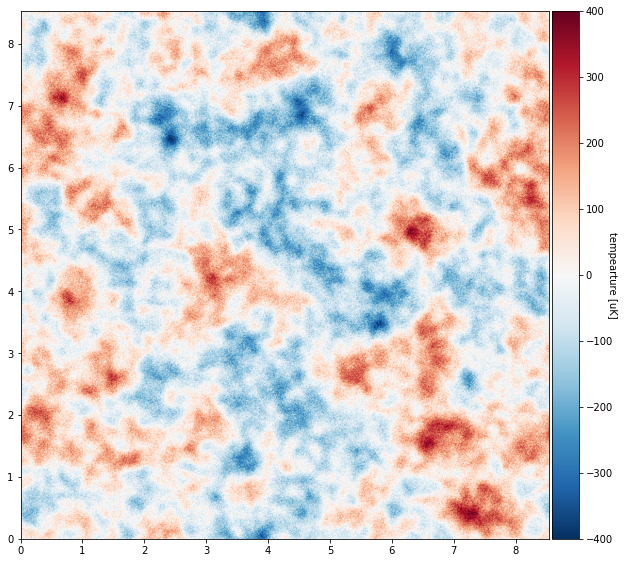

In [35]:
white_noise_level = 30 # units are uK-arcmin
def make_noise_map(npix,pix_size,white_noise_level):
    white_noise = np.random.normal(0,1,(npix,npix)) * white_noise_level/pix_size
    noise_map = np.real(white_noise)
    return(noise_map)

# making a noise map and additing it to the convolved map from above
Noise = make_noise_map(npix,pix_size,white_noise_level)
total = CMB_T_convolved + Noise

plot_map(total,10,10)
plt.savefig('Noise 30')

### Apodization filtering

If we were to immediately FFT this sky map, we would get strange results because of edge effects--that is, the boundaries of this map are not periodic boundary conditions. To account for this, we can implement an apodization filter that uses a Fourier transform window to smooth the edges to zero. Here I'm using a Gaussian window to return the edges to zero.

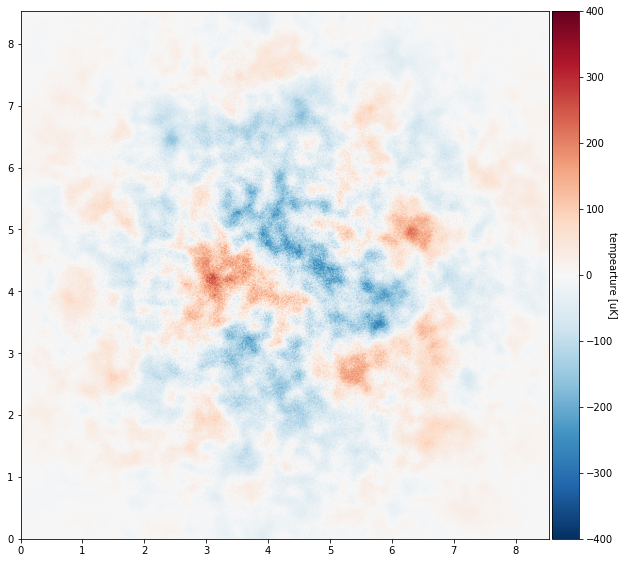

In [65]:
def gaussian_window(npix):
    
    # setting up the same 2D real space coordinates
    ones = np.ones(npix)
    inds = np.linspace(-0.5, 0.5, npix)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
  
    # creating this window function in the 2D space 
    sigma = 0.250
    window_map = np.exp(-(X**2)/(2*sigma**2)) * np.exp(-(Y**2)/(2*sigma**2))

    return(window_map)
  
    
window = gaussian_window(npix)
    
apodized_map = window * total # notice the filter is multiplied while noise was added

plot_map(apodized_map,10,10)
plt.savefig('Gaussian window')

<a id="power"> </a>

## FFT to recover power spectrum from map

To recover the power spectrum from a realistic CMB map, we take the 2D Fourier transform, average the signal in radial bins, and convert back to a multipole scale. 

In [67]:
delta = 50.
lmax = 2000.

def calculate_spectrum(Map1,Map2,delta,lmax,pix_size,npix):    
    # setting up a different 2D coordinate system in multipole space with the same scale factor relationship
    ones = np.ones(npix)
    inds  = (np.arange(npix)+.5 - npix/2.) /(npix-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    multi_scal = 2. * np.pi 
    multi2d = K * multi_scal
    
    # empty arrays to store spectrum
    nbins = int(lmax/delta)
    larray = np.arange(nbins)
    Carray = np.zeros(nbins)
    
    # Fourier transforming the maps
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    
    # extracting values to fill the spectrum
    i = 0
    while (i < nbins):
        larray[i] = (i + 0.5) * delta
        inds_in_bin = ((multi2d >= (i* delta)) * (multi2d < ((i+1)* delta))).nonzero()
        Carray[i] = np.mean(PSMap[inds_in_bin])
        i = i + 1
 
    return(larray,Carray*np.sqrt(pix_size /60* np.pi/180)*2)

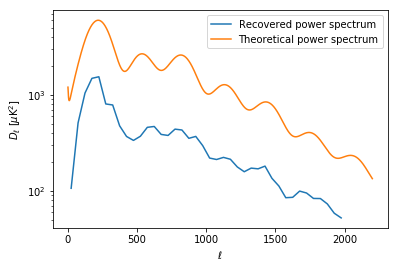

In [68]:
## using the function above to generate power spectrum from apodized map
recovered = calculate_spectrum(apodized_map, apodized_map, delta,lmax,pix_size,npix)

# plotting the recovered power spectrum along with the theoretical
plt.semilogy(recovered[0],recovered[1]* recovered[0] * (recovered[0]+1)/2 / np.pi, label="Recovered power spectrum")
plt.semilogy(standard[0],standard[1], label="Theoretical power spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.savefig('Naive power spectrum')
plt.show()


<a id="mcmc"> </a>

## Monte Carlo methods to calibrate bias terms

The recovered power spectrum above is biased with white noise, beam effects, and apodization filtering. In order to correct this, Monte Carlo simulations are run to calibrate the multiplicative and additive bias terms in the equation $$D_\ell = \hat (D_\ell - N)/T.$$ that relates the actual spectrum to the measured spectrum. Here, I'm only calibrating the multiplicative bias term since it has more of an effect on the power spectrum.


The simulations we need to run to determine the impact of instrumental effects are signal-only simulations (i.e. without any noise or beam convolution), since these were generated directly from known power spectra. We still need the apodization filter in order to get good Fourier transforms, so I'm multiplying the initial map by `window`.

I'm generating maps with the `cmb` data and recovering power spectra from them 20 times, since the simulations do take a bit of time, but 20 seems to be sufficient.

In [74]:
itr = 20
signal_only  = np.zeros([itr,int(lmax/delta)])
i = 0
while (i < itr):
    CMB_T = generate_map(npix,pix_size,standard[0],standard[1])
    sim = calculate_2d_spectrum(CMB_T*window,CMB_T*window,delta,lmax,pix_size,npix)
    signal_only[i,:] = sim[1]
    sys.stdout.write("\r signal only sims, iterations complete: %d of %d" % ((i+1),itr) )
    sys.stdout.flush()
    i = i + 1


 signal only sims, iterations complete: 20 of 20

Defining a function that can easily calculate and store the average spectrum of the simulations since something like `np.mean` is not enough to calculate the binned averages.

In [78]:
def average(spectra, itr):
    avgSpectra = np.zeros(int(lmax/delta))
    
    i = 0
    while (i < itr):
        avgSpectra = avgSpectra + spectra[i,:]
        i = i + 1
    avgSpectra = avgSpectra/(1. * itr)
    
    return avgSpectra

To calculate the bias term, we average the signal-only simulations and divide the recovered spectrum by this average controlled simulation spectrum. To calibrate the spectrum with this bias term, we multiply the amplitudes of the plot by `bias`.

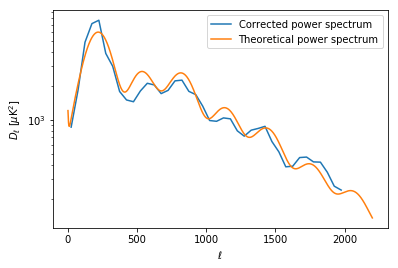

In [80]:
# calculating bias
sig_spectrum = average(signal_only,itr)
bias = (standard[1][recovered[0]] * 2. * np.pi / (recovered[0] * (recovered[0]+1.))) / sig_spectrum

# plotting corrected power spectrum that accounts for bias
plt.clf()
plt.semilogy(recovered[0],(recovered[1])*bias* recovered[0] * (recovered[0]+1.)/2. / np.pi,label= "Corrected power spectrum")
plt.semilogy(standard[0],standard[1], label="Theoretical power spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.savefig('Corrected power spectrum')
plt.show()




By bringing the amplitudes of the recovered power spectrum up to those of the theoretical, the MCMC simulations and bias term have successfully added a correction that is necessary in data analysis when you have instrumental effects. If we were doing this without a known signal, we would have to study the beam to model its effects and test different ways to reduce noise.

<a id="act"> </a>

## Comparing ACT power spectrum to models

How do we know that we live in a Lambda-CDM universe? The data from high-resolution CMB experiments has given us power spectra that correspond to the cosmological parameters of this model.

Here, we take a look at real data from the Atacama Cosmology Telescope's third observation season in the 148 GHz frequency band. 

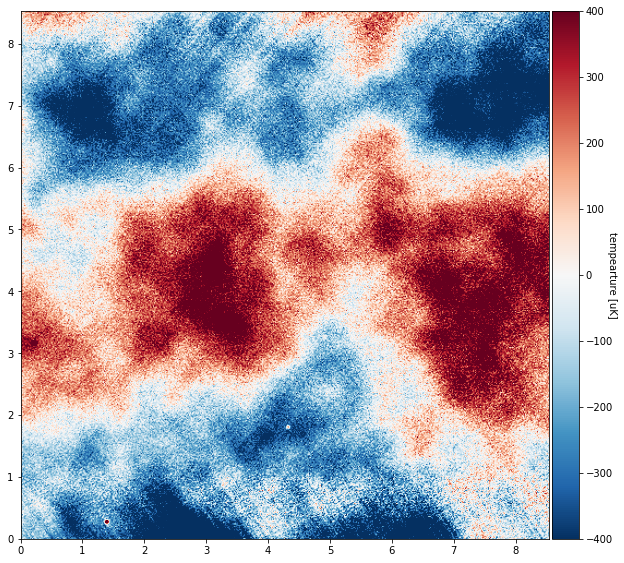

In [82]:
# loading map and its data
map = fits.getdata('ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('ACT_Season3_148_GHz_submap.fits')

# cutting a patch out of the map
Ny= header['NAXIS2']
N=int(Ny) 
map_patch = map[0:int(N), 0:int(N)] 

# plotting sky patch
plot_map(map_patch,10,10)
plt.savefig('ACT real')

Apodizing the map so we can use our functions on it

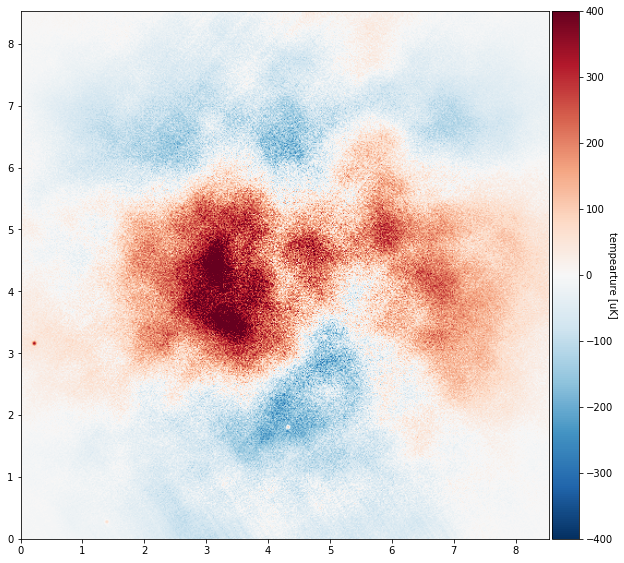

In [83]:
window = (gaussian_window(N))
real_map = window * map_patch
plot_map(real_map,10,10)
plt.savefig('ACT apodized')

Using the methods defined above to recover power spectra from maps, I've plotted the theoretical, recovered, and real data power spectra. The real data is biased on large scales from atmospheric noise, which I didn't include in my models.

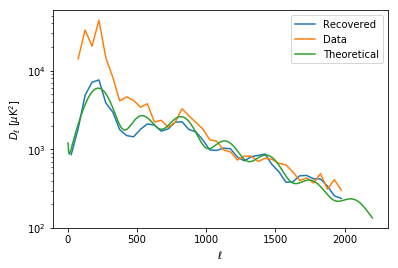

In [90]:
delta = 50
lmax = 2000

        
theory = calculate_spectrum(apodized_map,apodized_map,delta,lmax,pix_size,npix)
data = calculate_spectrum(real_map,real_map,delta,lmax,pix_size,N)

plt.semilogy(theory[0],(theory[1])*bias* theory[0] * (theory[0]+1.)/2. / np.pi, label='Recovered')
plt.semilogy(data[0],data[1]*data[0] * (data[0]+1.)/2. / np.pi, label='Data')
plt.semilogy(standard[0],standard[1], label='Theoretical')

plt.legend()
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Here, I've plotted the real data along with the 4 model universes from the beginning. It is clear that 2 of the 4 model universes do not align with the data. However, the data seems to be similar to both the Lambda-CDM universe and the quintessence universe (again, this is due to parameter degeneracy), which is why additional tests like measurements of type-IA supernovae are useful in studying dark energy and “cosmic coincidence.”


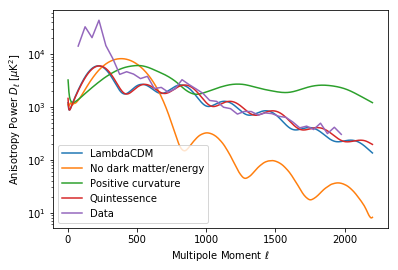

In [91]:
plt.semilogy(standard[0], standard[1], label='LambdaCDM')
plt.semilogy(nodark[0], nodark[1], label='No dark matter/energy')
plt.semilogy(curve[0], curve[1], label='Positive curvature')
plt.semilogy(quint[0], quint[1], label='Quintessence')
plt.semilogy(data[0],data[1]*data[0] * (data[0]+1.)/2. / np.pi, label='Data')

plt.ylabel('Anisotropy Power $D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('Multipole Moment $\ell$')


plt.legend()
plt.savefig('Power Spectra')
plt.show()

<a id="ref"> </a>

## References

### Background:

Filippini, Jeff.  “The Cosmic Microwave Background.”  UC Berkeley Cosmology Group. August 2005. http://cosmology.berkeley.edu/Education/CosmologyEssays/The_Cosmic_Microwave_Background.html.

Kavli Institute for Cosmology, Cambridge. “CMB Power Spectra, Likelihood, and Cosmological Parameters.” https://www.kicc.cam.ac.uk/research/cosmic-microwave-background-and-the-early-universe/CMB-cosmological-parameters.

M. Tanabashi et al. (Particle Data Group), Phys. Rev. D 98, 030001 (2018). https://doi.org/10.1103/PhysRevD.98.030001. 

Lewis, Antony. “CAMB Notes.” DAMTP/CITA/IoA/Sussex, April 2, 2014. https://cosmologist.info/notes/CAMB.pdf. 

Steinhardt, Paul J. “A Quintessential Introduction to Dark Energy.” Philosophical Transactions of the Royal Society of London. Series A: Mathematical, Physical and Engineering Sciences 361, no. 1812 (November 15, 2003): 2497–2513. https://doi.org/10.1098/rsta.2003.1290.


### Code and Data:

This code is based on Jeff McMahon and Renee Hlozek’s CMB School interactive notebooks. I worked through all the notebooks and then chose certain techniques that I wanted to use to go from power spectra to maps, maps to power spectra, plot strange model universes, etc. I tried my best to use the notebooks as a resource for things I wouldn't have otherwise known how to do in working with raw CMB data, and designed my own project around exploring CMB probes of cosmological parameters using these methods. The ACT data was also provided in the CMB School Github.